In [1]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append('../src/')
from configs import *
from utils import *
from scipy.io import loadmat
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from IPython.display import display

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
rcParams.update(fig_params)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
data = loadmat('../data/v_soc.mat')
C, Q, Qc, Vc = data['C'], data['Q'], data['Qc'], data['Vc']

## Global parameters

In [3]:
SEED = SEED           # random state for reproducibility
M = Qc.shape[1]       # number of curves
M_train = 50          # number of curves to use for training
M_test = M - M_train  # number of curves to use for testing
N = 10000             # number of data points for training
TARGET = 'q(V_min)'   # target variable
NUM_FOLDS = 5         # cross-validation folds
sampling_lb = 2       # sampling lower bound
sampling_ub = 6       # sampling upper bound
min_distance = 1      # minimum q distance between couples of sampled points

## Data visualization

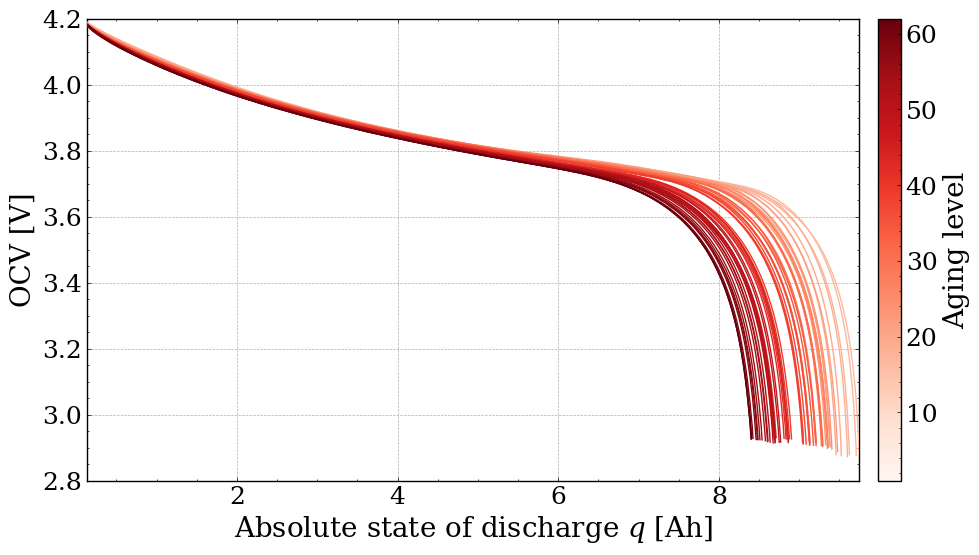

In [4]:
fig_params['axes.labelsize'] = 20
fig_params['xtick.labelsize'] = 18
fig_params['ytick.labelsize'] = 18
fig_params['legend.fontsize'] = 16
fig_params['axes.titlesize'] = 20
fig_params['axes.grid'] = True
rcParams.update(fig_params)

colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    plt.plot(q, Voc, color=colors[i], zorder=10)

plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
plt.margins(0)
plt.ylim(2.8, 4.2)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

In [6]:
# FIG_SIZE = (12,6)
# SAVE_FIG = True
# FIG_FMT = 'pdf'
# TRANSPARENT_PNG=True

# save_fig(
#     fig,
#     'OCV_curves',
#     fig_dir=os.path.join('..','figures'),
#     fig_fmt=FIG_FMT,
#     save=SAVE_FIG, 
#     fig_size=FIG_SIZE,
#     transparent_png=TRANSPARENT_PNG,
# )

## Dataframe creation

In [7]:
df_list = []

for i in range(M): 
    q = Qc[0][i]
    Voc = Vc[0][i]
    assert(q.shape[0] == Voc.shape[0])
    assert(np.isclose(q[-1], C[i]))
    
    tmp = pd.DataFrame(data=0.0, index=range(q.shape[0]), columns=['Curve_id', 'Q', 'q', 'V_oc', 'q(V_min)'])
    tmp['Curve_id'] = i
    tmp['Q'] = Q[i].item()
    tmp['q'] = q
    tmp['V_oc'] = Voc
    tmp['q(V_min)'] = C[i].item()
    
    df_list.append(tmp)

df = pd.concat(df_list, ignore_index=True)

In [8]:
df_grouped = df[(df['q'] >= sampling_lb) & (df['q'] <= sampling_ub)].groupby('Curve_id')

df_list = Parallel(n_jobs=M, verbose=10)(delayed(sampling_from_group)(curve_id, group_df, N, M, SEED, min_distance) for curve_id, group_df in df_grouped)

comb = pd.concat(df_list, ignore_index=True)

[Parallel(n_jobs=62)]: Using backend LokyBackend with 62 concurrent workers.
[Parallel(n_jobs=62)]: Done   2 out of  62 | elapsed:    3.5s remaining:  1.7min
[Parallel(n_jobs=62)]: Done   9 out of  62 | elapsed:    3.6s remaining:   21.4s
[Parallel(n_jobs=62)]: Done  16 out of  62 | elapsed:    3.7s remaining:   10.6s
[Parallel(n_jobs=62)]: Done  23 out of  62 | elapsed:    3.8s remaining:    6.4s
[Parallel(n_jobs=62)]: Done  30 out of  62 | elapsed:    3.8s remaining:    4.1s
[Parallel(n_jobs=62)]: Done  37 out of  62 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=62)]: Done  44 out of  62 | elapsed:    4.0s remaining:    1.6s
[Parallel(n_jobs=62)]: Done  51 out of  62 | elapsed:    4.0s remaining:    0.9s
[Parallel(n_jobs=62)]: Done  58 out of  62 | elapsed:    4.1s remaining:    0.3s
[Parallel(n_jobs=62)]: Done  62 out of  62 | elapsed:    4.1s finished


In [9]:
comb

,Curve_id,Q,q1,V_oc1,q2,V_oc2,q(V_min)
0,0.0,4.773851,4.368757,3.838781,5.475477,3.791293,9.745374
1,0.0,4.773851,3.317387,3.896135,5.198788,3.801878,9.745374
2,0.0,4.773851,4.285758,3.842921,5.392464,3.794168,9.745374
3,0.0,4.773851,3.206711,3.902949,5.558484,3.787981,9.745374
4,0.0,4.773851,3.289720,3.897710,5.779819,3.779815,9.745374
...,...,...,...,...,...,...,...
9977,61.0,23864.359441,2.157169,3.954600,3.680173,3.855022,8.402317
9978,61.0,23864.359441,4.760067,3.800205,5.812316,3.754085,8.402317
9979,61.0,23864.359441,3.624789,3.858458,5.480021,3.768221,8.402317
9980,61.0,23864.359441,4.953901,3.791169,5.978459,3.746375,8.402317


## Samples visualization

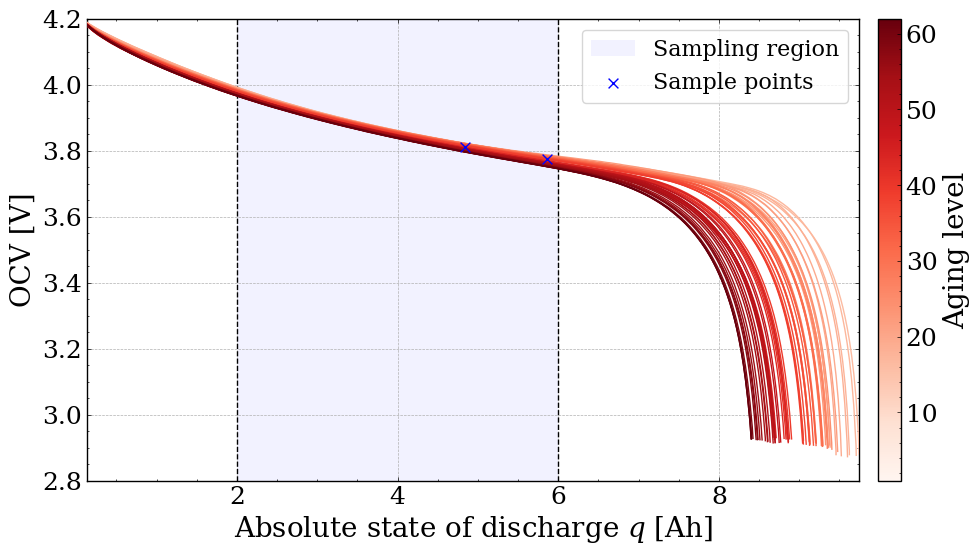

In [10]:
colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    plt.plot(q, Voc, color=colors[i], zorder=10)
    
rnd_sample = comb.sample(n=1)
x1, y1 = rnd_sample['q1'].item(), rnd_sample['V_oc1'].item()
x2, y2 = rnd_sample['q2'].item(), rnd_sample['V_oc2'].item()
sample = plt.scatter(x1, y1, marker='x', color='b', zorder=20, s=50)
plt.scatter(x2, y2, marker='x', color='b', zorder=20, s=50)

plt.axvline(sampling_lb, linestyle='--', color='k')
plt.axvline(sampling_ub, linestyle='--', color='k')
#plt.title('OCV curves', fontsize=14)
plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
area = plt.axvspan(sampling_lb, sampling_ub, color='b', alpha=0.05, lw=0)
plt.legend([area, sample], ['Sampling region', 'Sample points'])
plt.margins(0)
plt.ylim(2.8, 4.2)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

## Train test split

In [11]:
rng = np.random.default_rng(SEED)
test_curves = sorted(rng.choice(range(1, M-1), size=M_test, replace=False).tolist())
test_curves

[5, 6, 12, 23, 32, 34, 39, 40, 47, 53, 55, 59]

In [12]:
train_curves = list(set(range(62)).difference(set(test_curves)))

train_idx = comb[comb['Curve_id'].isin(train_curves)].index
test_idx = comb[comb['Curve_id'].isin(test_curves)].index

comb['Dataset'] = ''
comb.loc[train_idx, 'Dataset'] = 'train'
comb.loc[test_idx, 'Dataset'] = 'test'

train = comb[comb['Dataset'] == 'train'].reset_index(drop=True).copy()
test = comb[comb['Dataset'] == 'test'].reset_index(drop=True).copy()

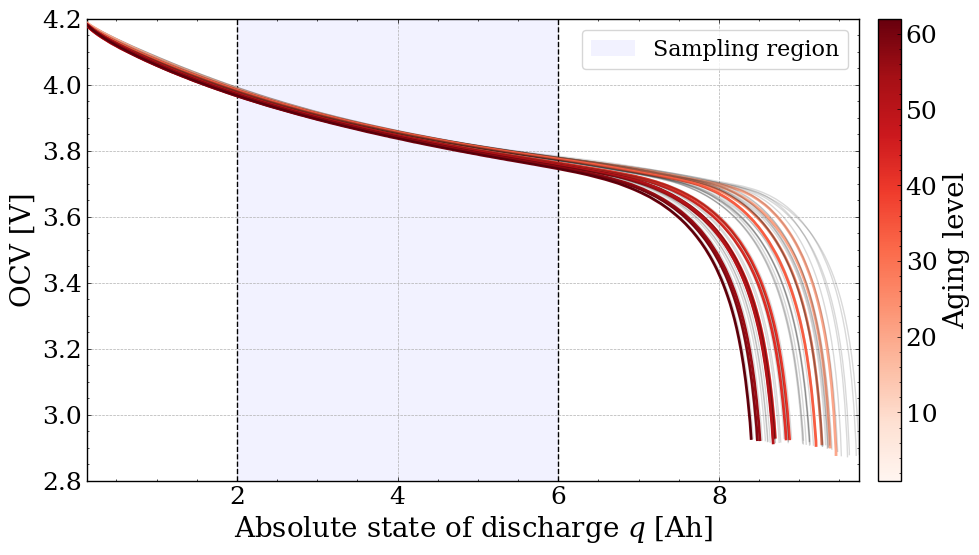

In [13]:
colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    if i in train_curves:
        plt.plot(q, Voc, color='k', zorder=10, alpha=0.15)
    else:
        plt.plot(q, Voc, color=colors[i], zorder=10, lw=2)

plt.axvline(sampling_lb, linestyle='--', color='k')
plt.axvline(sampling_ub, linestyle='--', color='k')
#plt.title('OCV curves', fontsize=14)
plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
area = plt.axvspan(sampling_lb, sampling_ub, color='b', alpha=0.05, lw=0)
plt.legend([area], ['Sampling region'])
plt.margins(0)
plt.ylim(2.8, 4.2)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

##  Naive model

In [14]:
res_naive = test.copy()
res_naive['preds'] = train[TARGET].mean()

In [15]:
compute_metrics(true=res_naive[TARGET].values, preds=res_naive['preds'].values, fold='Test')

,MAPE,MAE,RMSE,R2
Test,3.96888,0.349471,0.376997,-0.135684


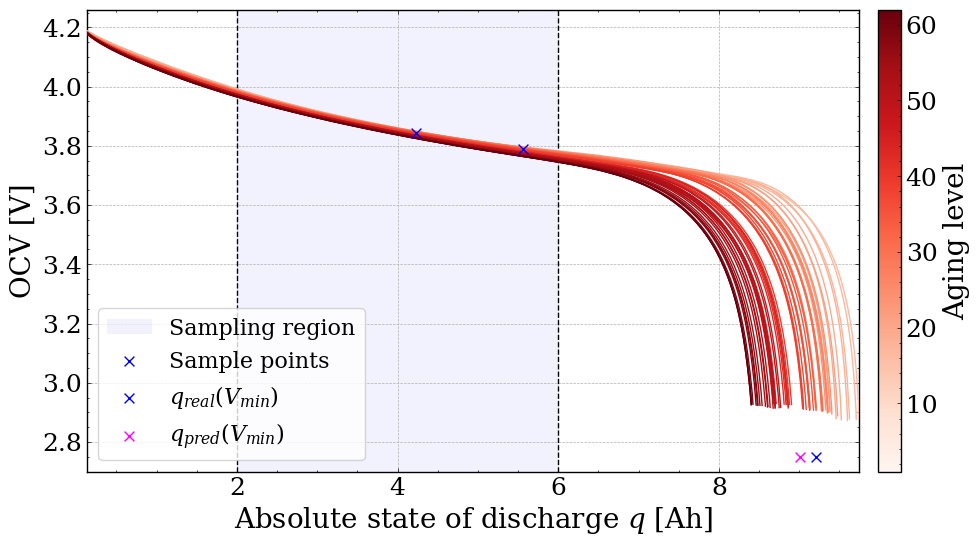

In [16]:
colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    plt.plot(q, Voc, color=colors[i], zorder=10)
    
rnd_sample = res_naive.sample(n=1)
x1, y1 = rnd_sample['q1'].item(), rnd_sample['V_oc1'].item()
x2, y2 = rnd_sample['q2'].item(), rnd_sample['V_oc2'].item()
actual, pred = rnd_sample[TARGET].item(), rnd_sample['preds'].item()
sample_scatter = plt.scatter(x1, y1, marker='x', color='b', zorder=20, s=50)
plt.scatter(x2, y2, marker='x', color='b', zorder=20, s=50)
actual_scatter = plt.scatter(actual, 2.75, marker='x', color='b', zorder=20, s=50)
pred_scatter = plt.scatter(pred, 2.75, marker='x', color='magenta', zorder=20, s=50)

plt.axvline(sampling_lb, linestyle='--', color='k')
plt.axvline(sampling_ub, linestyle='--', color='k')
#plt.title('OCV curves', fontsize=14)
plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
area = plt.axvspan(sampling_lb, sampling_ub, color='b', alpha=0.05, lw=0)
plt.legend([area, sample_scatter, actual_scatter, pred_scatter], ['Sampling region', 'Sample points', r'$q_{real}(V_{min})$', r'$q_{pred}(V_{min})$'])
plt.gca().set_ylim(bottom=2.7)
plt.margins(0)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

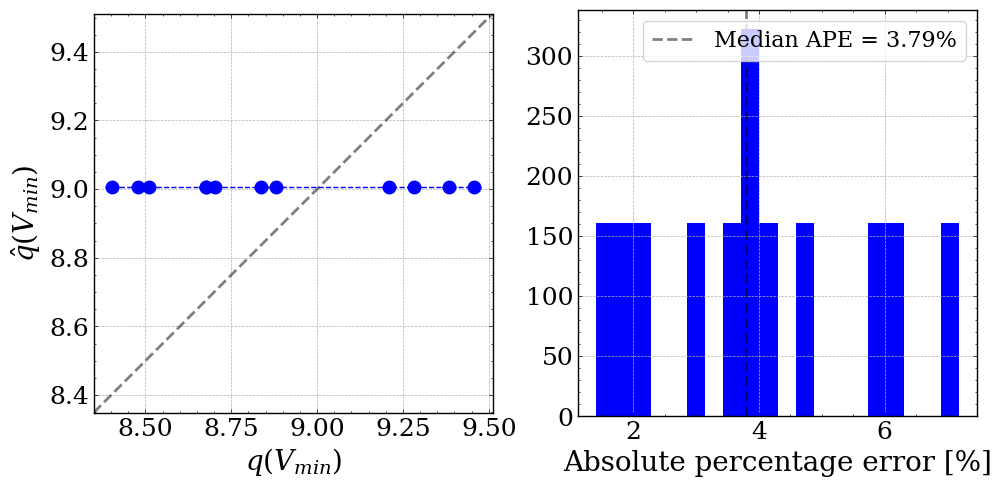

In [17]:
fig= plot_diagnostic(res_naive, target=TARGET, fold=None, bins=20, percentiles=(.05, .95), figsize=(10,5))

## Baseline model

In [18]:
index_cols = ['Curve_id', 'Q', 'Dataset']

features = ['q1', 'V_oc1', 'q2', 'V_oc2']

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train mape: 0.00676726 + 0.000206714	cv_agg's valid mape: 0.00887132 + 0.000866163
[200]	cv_agg's train mape: 0.00598441 + 0.00019923	cv_agg's valid mape: 0.00863838 + 0.000941589
Early stopping, best iteration is:
[226]	cv_agg's train mape: 0.00589616 + 0.000194244	cv_agg's valid mape: 0.0086215 + 0.000951351
[100]	training's mape: 0.00684087	valid_1's mape: 0.00618589
[200]	training's mape: 0.00618876	valid_1's mape: 0.0059957


,MAPE,MAE,RMSE,R2
Fold,,,,
OOF,0.862150,0.079583,0.120616,0.888820
Test ensemble,0.585971,0.052625,0.071877,0.958718
Test refit,0.594409,0.053432,0.073394,0.956957


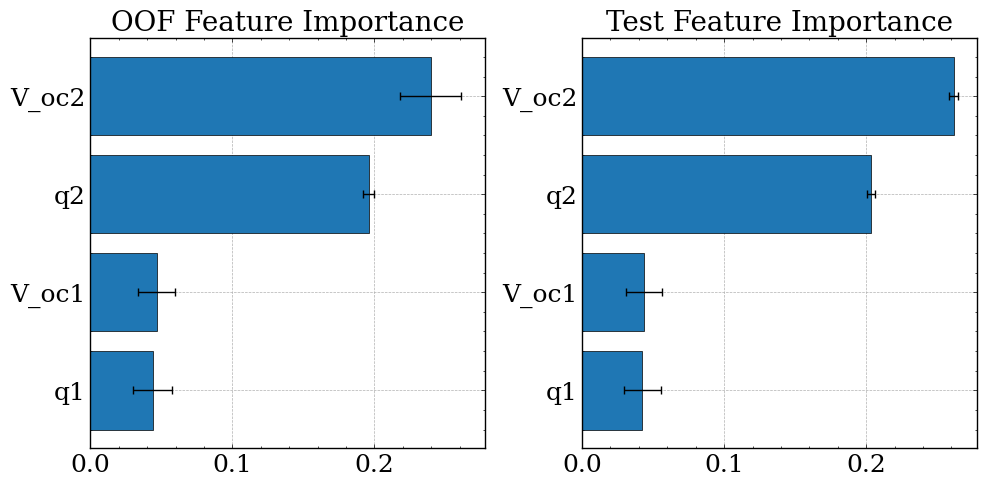

In [19]:
res_baseline = cross_validate(train=train,
                              test=test,
                              features=features,
                              target=TARGET,
                              params=PARAMS_GB,
                              num_folds=NUM_FOLDS,
                              refit=True,
                              refit_multiplier=1.2,
                              log=100,
                              verbose=True,
                              feval=None,
                              compute_oof_importance=True,
                              compute_test_importance=True)
print_results(res_baseline)
plot_importance(res_baseline, features=features, max_features=20)

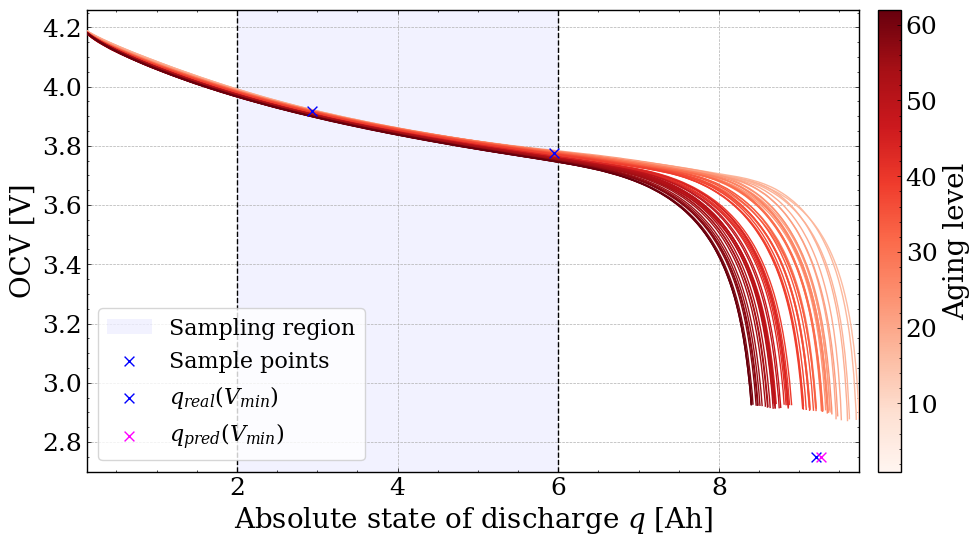

In [20]:
colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    plt.plot(q, Voc, color=colors[i], zorder=10)
    
rnd_sample = res_baseline['test_preds'].sample(n=1)
x1, y1 = rnd_sample['q1'].item(), rnd_sample['V_oc1'].item()
x2, y2 = rnd_sample['q2'].item(), rnd_sample['V_oc2'].item()
actual, pred = rnd_sample[TARGET].item(), rnd_sample['preds_ensemble'].item()
sample_scatter = plt.scatter(x1, y1, marker='x', color='b', zorder=20, s=50)
plt.scatter(x2, y2, marker='x', color='b', zorder=20, s=50)
actual_scatter = plt.scatter(actual, 2.75, marker='x', color='b', zorder=20, s=50)
pred_scatter = plt.scatter(pred, 2.75, marker='x', color='magenta', zorder=20, s=50)

plt.axvline(sampling_lb, linestyle='--', color='k')
plt.axvline(sampling_ub, linestyle='--', color='k')
#plt.title('OCV curves', fontsize=14)
plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
area = plt.axvspan(sampling_lb, sampling_ub, color='b', alpha=0.05, lw=0)
plt.legend([area, sample_scatter, actual_scatter, pred_scatter], ['Sampling region', 'Sample points', r'$q_{real}(V_{min})$', r'$q_{pred}(V_{min})$'])
plt.gca().set_ylim(bottom=2.7)
plt.margins(0)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

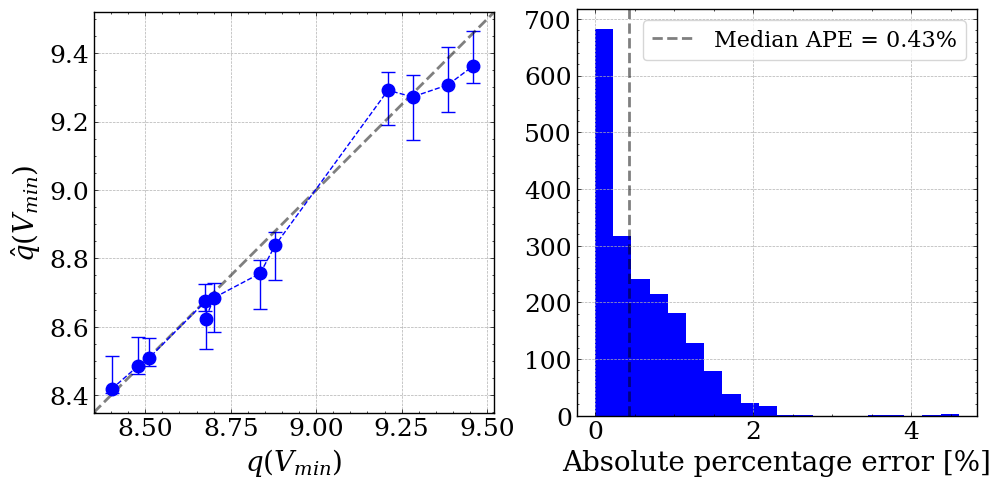

In [21]:
fig = plot_diagnostic(res_baseline, target=TARGET, fold='test', bins=20, percentiles=(.05, .95), figsize=(10,5))

## Feature engineering

In [22]:
def add_features(df):
    df = df.copy()
    x1, y1 = df['q1'].copy(), df['V_oc1'].copy()
    x2, y2 = df['q2'].copy(), df['V_oc2'].copy()
    # Delta of x and y coordinates
    df['dy'] = y2 - y1
    df['dx'] = x2 - x1
    # Slope of the line segment
    df['slope'] = df['dy'] / df['dx']
    # Harmonic Mean of Y Coordinates
    df['harmonic_mean_y'] = 2 / (1/y1 + 1/y2)
    # Euclidean Distance from Fixed Points
    fixed_x, fixed_y = 6, 4
    df['distance_from_fixed_point_2'] = np.sqrt((fixed_x - x2)**2 + (fixed_y - y2)**2)
    # Midpoint coordinates
    df['midpoint_y'] = (y1 + y2) / 2
    features = ['slope', 'harmonic_mean_y', 'distance_from_fixed_point_2', 'midpoint_y']
    return df, features

In [23]:
comb, computed_features = add_features(comb)
train = comb[comb['Dataset'] == 'train'].reset_index(drop=True).copy()
test = comb[comb['Dataset'] == 'test'].reset_index(drop=True).copy()

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train mape: 0.00643047 + 0.000274639	cv_agg's valid mape: 0.00882038 + 0.0009825
[200]	cv_agg's train mape: 0.00568909 + 0.000188303	cv_agg's valid mape: 0.00862077 + 0.00105239
[300]	cv_agg's train mape: 0.00532813 + 0.000238888	cv_agg's valid mape: 0.00850903 + 0.00099521
[400]	cv_agg's train mape: 0.00500433 + 0.000179668	cv_agg's valid mape: 0.00839724 + 0.00101274
[100]	training's mape: 0.00669206	valid_1's mape: 0.00582119
[200]	training's mape: 0.00575851	valid_1's mape: 0.00540275
[300]	training's mape: 0.00546846	valid_1's mape: 0.00533638
[400]	training's mape: 0.00525856	valid_1's mape: 0.00530665


,MAPE,MAE,RMSE,R2
Fold,,,,
OOF,0.839059,0.077609,0.119114,0.890002
Test ensemble,0.480949,0.043467,0.060458,0.970793
Test refit,0.523223,0.047182,0.064097,0.967171


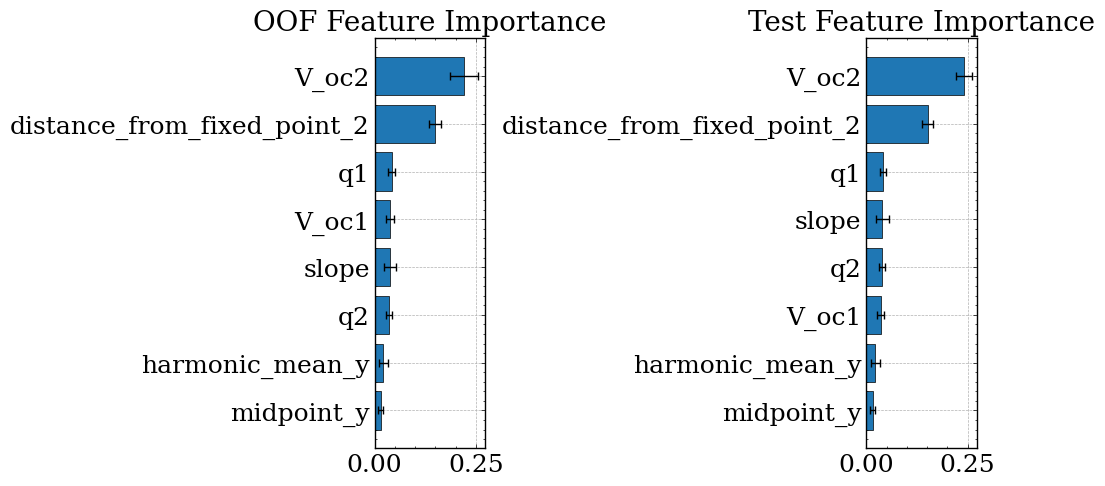

In [24]:
res_engineered = cross_validate(train=train,
                                test=test,
                                features=features + computed_features,
                                target=TARGET,
                                params=PARAMS_GB,
                                num_folds=NUM_FOLDS,
                                refit=True,
                                refit_multiplier=1.2,
                                log=100,
                                verbose=True,
                                feval=None,
                                compute_oof_importance=True,
                                compute_test_importance=True)
print_results(res_engineered)
plot_importance(res_engineered, features=features+computed_features, max_features=20)

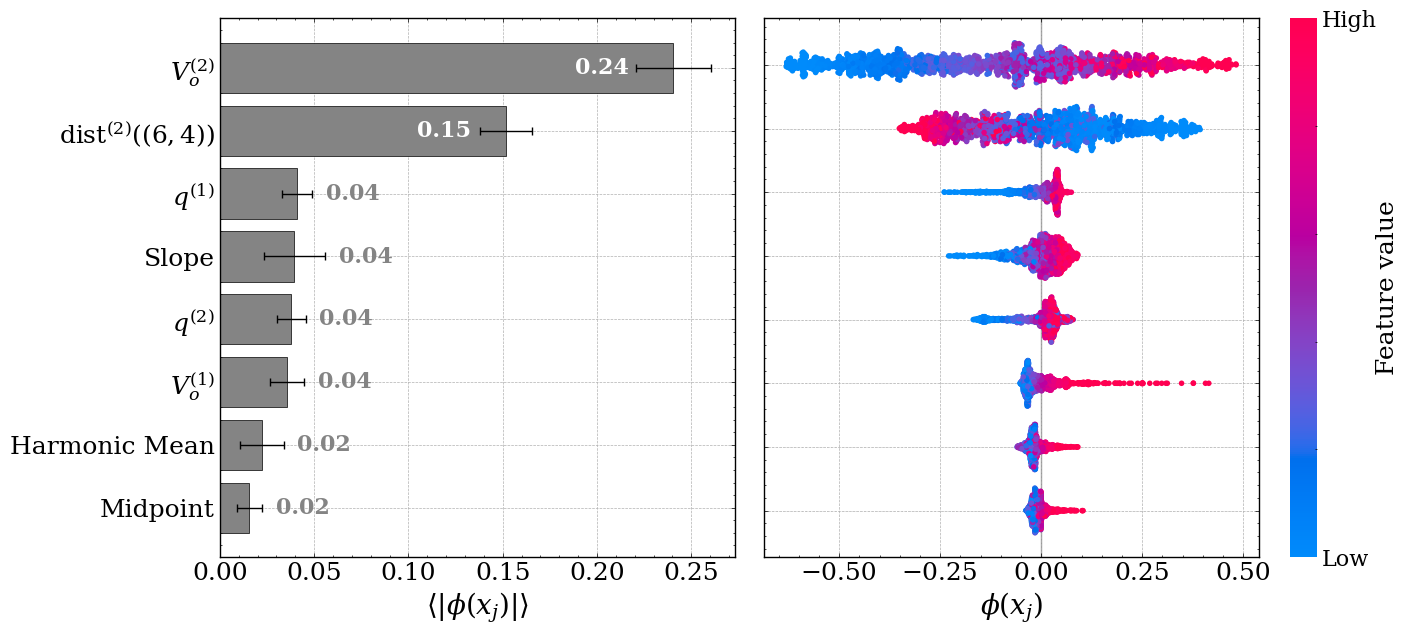

In [33]:
import shap
import matplotlib.gridspec as gridspec
from _colors import blue_rgb, red_rgb, gray_rgb

f = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1.2], wspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
axes=(ax1,ax2)

plt.sca(axes[0])
test_feature_importance = res_engineered['test_feature_importance']
test_imps = [pd.DataFrame(test_feature_importance[f], columns=features + computed_features + ['expected_values'])\
            [features + computed_features].abs().mean(axis=0).to_frame(name=f'fold{f+1}') for f in range(len(test_feature_importance))]
test_imps = reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True, right_index=True), test_imps)
test_imps = test_imps.agg(['mean', 'std'], axis=1).sort_values(by='mean', ascending=False)

bars = axes[0].barh(y=test_imps.index.values, width=test_imps['mean'].values, xerr=test_imps['std'].values, error_kw=dict(ecolor='black', zorder=2), 
                    capsize=3, edgecolor='black', linewidth=0.5, zorder=1, color=gray_rgb)

axes[0].invert_yaxis()
axes[0].set_axisbelow(True)
bar_labels = axes[0].bar_label(bars, padding=-60, color='white', fontsize=16, label_type='edge', fmt='%.2f',fontweight='bold')
bar_labels[0].set_position((-98, 0))
bar_labels[1].set_position((-83, 0))
bar_labels[2].set_position((+10, 0))
bar_labels[2].set_color(gray_rgb)
bar_labels[3].set_position((+10, 0))
bar_labels[3].set_color(gray_rgb)
bar_labels[4].set_position((+10, 0))
bar_labels[4].set_color(gray_rgb)
bar_labels[5].set_position((+10, 0))
bar_labels[5].set_color(gray_rgb)
bar_labels[6].set_position((+10, 0))
bar_labels[6].set_color(gray_rgb)
bar_labels[7].set_position((+10, 0))
bar_labels[7].set_color(gray_rgb)
axes[0].set_yticklabels([r'$V_{o}^{(2)}$', r'dist$^{(2)}((6,4))$', r'$q^{(1)}$', 'Slope', r'$q^{(2)}$', r'$V_{o}^{(1)}$', 'Harmonic Mean', 'Midpoint'])
axes[0].set_xlabel(r"$\langle|\phi(x_j)|\rangle$", fontsize=20)

plt.sca(axes[1])
shap.summary_plot(np.mean(res_engineered['test_feature_importance'], axis=0)[:,:-1], test[features+computed_features], show=False, auto_size_plot=False)
figshap, axshap = plt.gcf(), plt.gca()
axshap.tick_params(labelsize=18)
axshap.set_yticklabels([])
axshap.set_xlabel(r"$\phi(x_j)$", fontsize=20)
cb_ax = figshap.axes[2] 
cb_ax.tick_params(labelsize=16)
cb_ax.set_ylabel("Feature value", fontsize=18)
#cb_ax.tick_params(direction='out', length=6, width=20, grid_alpha=0.5)
# axes[1].set_yticklabels([])
# axes[1].tick_params(labelsize=18)
f.set_size_inches(15,7)
# plt.show()

In [35]:
# FIG_SIZE = (12,6)
# SAVE_FIG = True
# FIG_FMT = 'pdf'
# TRANSPARENT_PNG=True

# save_fig(
#     f,
#     'feature_importance',
#     fig_dir=os.path.join('..','figures'),
#     fig_fmt=FIG_FMT,
#     save=SAVE_FIG, 
#     fig_size=FIG_SIZE,
#     transparent_png=TRANSPARENT_PNG,
# )

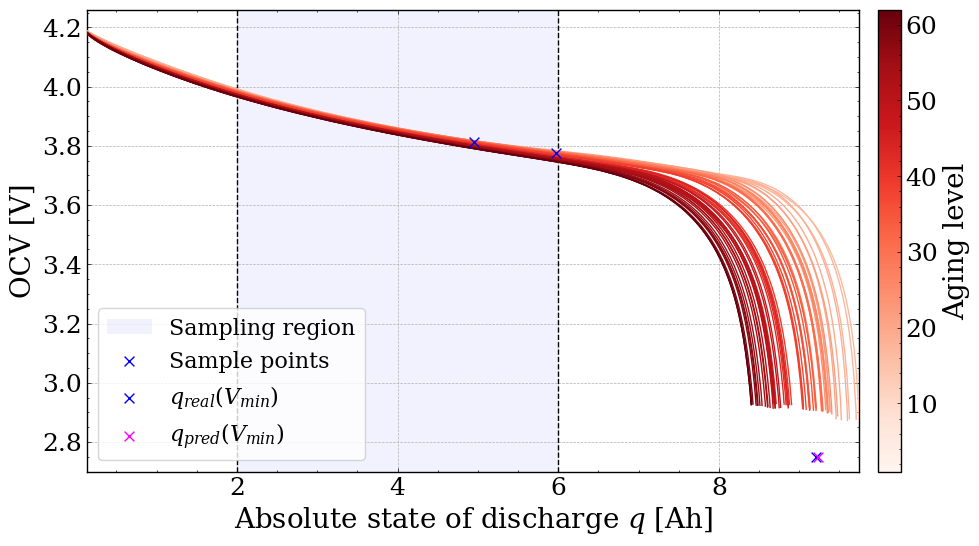

In [30]:
colors = plt.cm.Reds(np.linspace(0.25, 1.0, M))

fig = plt.figure(figsize=(12,6))

for i in range(M):
    q = Qc[0][i]
    Voc = Vc[0][i]
    
    plt.plot(q, Voc, color=colors[i], zorder=10)
    
rnd_sample = res_engineered['test_preds'].sample(n=1)
x1, y1 = rnd_sample['q1'].item(), rnd_sample['V_oc1'].item()
x2, y2 = rnd_sample['q2'].item(), rnd_sample['V_oc2'].item()
actual, pred = rnd_sample[TARGET].item(), rnd_sample['preds_ensemble'].item()
sample_scatter = plt.scatter(x1, y1, marker='x', color='b', zorder=20, s=50)
plt.scatter(x2, y2, marker='x', color='b', zorder=20, s=50)
actual_scatter = plt.scatter(actual, 2.75, marker='x', color='b', zorder=20, s=50)
pred_scatter = plt.scatter(pred, 2.75, marker='x', color='magenta', zorder=20, s=50)

plt.axvline(sampling_lb, linestyle='--', color='k')
plt.axvline(sampling_ub, linestyle='--', color='k')
#plt.title('OCV curves', fontsize=14)
plt.ylabel('OCV [V]')
plt.xlabel(r'Absolute state of discharge $q$ [Ah]')
area = plt.axvspan(sampling_lb, sampling_ub, color='b', alpha=0.05, lw=0)
plt.legend([area, sample_scatter, actual_scatter, pred_scatter], ['Sampling region', 'Sample points', r'$q_{real}(V_{min})$', r'$q_{pred}(V_{min})$'])
plt.gca().set_ylim(bottom=2.7)
plt.margins(0)
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(1, 62), cmap='Reds'), orientation='vertical', label='Aging level', pad=0.02);

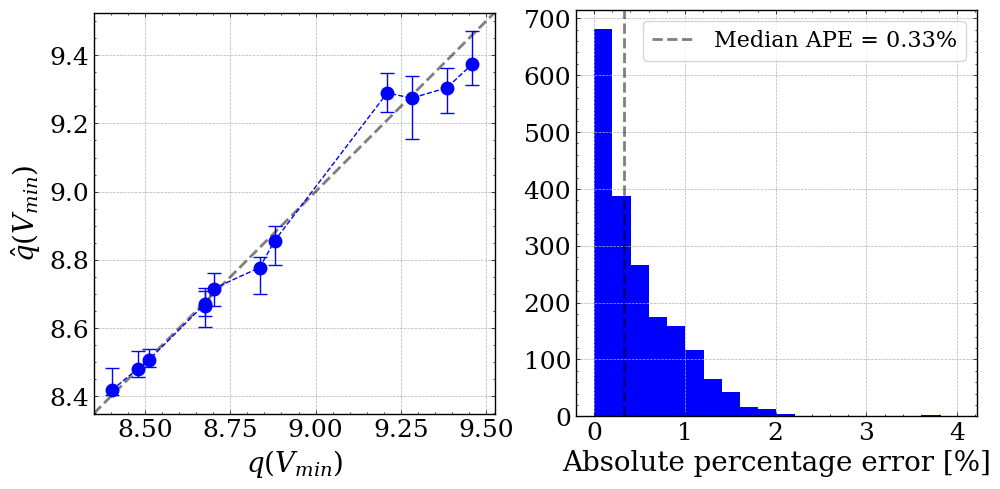

In [31]:
fig = plot_diagnostic(res_engineered, target=TARGET, fold='test', bins=20, percentiles=(.05, .95), figsize=(10,5))

In [32]:
# FIG_SIZE = (10,5)
# SAVE_FIG = True
# FIG_FMT = 'pdf'
# TRANSPARENT_PNG=True

# save_fig(
#     fig,
#     'error_diagnostics',
#     fig_dir=os.path.join('..','figures'),
#     fig_fmt=FIG_FMT,
#     save=SAVE_FIG, 
#     fig_size=FIG_SIZE,
#     transparent_png=TRANSPARENT_PNG,
# )